# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [52]:
# Load pickled data
import pickle
import numpy as np

training_file = "Data/train.p"
testing_file = "Data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

# Combine the train and test set
X_data, y_data = np.concatenate((X_train, X_test), axis=0), np.concatenate((y_train, y_test), axis=0)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [53]:
n_train = X_train.shape[0]
n_test = X_test.shape[0]
image_shape = (X_train.shape[1], X_train.shape[2])
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [54]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

Lets take a look at an image to get an idea of what we're dealing with:

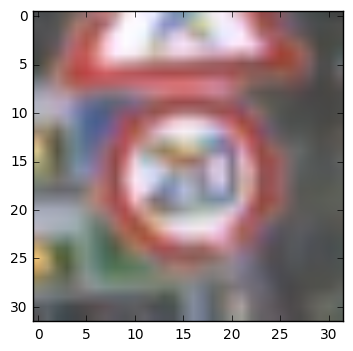

In [55]:
plt.imshow(X_data[0,...])

The image seems a little blurier than what I was expecting, but it is clear enough for me to easily see that it is a 20kph speed sign. 

## Normalization
Now that we have an idea of what an image from the dataset looks like, we need to normalize the images so that the optimizer in our model has an easier time converging. My implementation is as follows:
  * Convert the image to grayscale  
  * Equalize the histogram to account for variations in lighting conditions  
  * Divide by 255 and subtract 0.5 to clip the pixel range to [-0.5, 0.5]  

The below example shows the effect of this technique on a particularly difficult image.

Label: 6


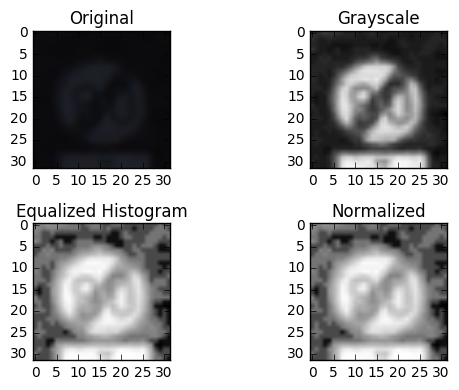

In [4]:
# Choose an image to visualize
im = 10000

# Copy the image
orig = np.copy(X_train[im,...])
print('Label: %d' % (y_train[im]))

# Convert to grayscale
gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)

# Equalize the histogram
eq_gray = cv2.equalizeHist(gray)

# Normalize the values
norm_gray = eq_gray/255. - 0.5

# Plot the results
fig = plt.figure()

grid = plt.subplot(2,2,1)
grid.set_title('Original')
grid.imshow(orig)

grid = plt.subplot(2,2,2)
grid.set_title('Grayscale')
grid.imshow(gray, cmap='gray')

grid = plt.subplot(2,2,3)
grid.set_title('Equalized Histogram')
grid.imshow(eq_gray, cmap='gray')

grid = plt.subplot(2,2,4)
grid.set_title('Normalized')
grid.imshow(norm_gray, cmap='gray')

plt.tight_layout()
plt.show()

As you can see, the difference between the original image and the final result is massive! It is now **much** easier to discern that this is a 80kph speed sign. The hope is that the model will percieve the same differences :)

## Class Distribution
Another worry when training a model is that the number of observations from each class will not be similar. This can be an issue at times if, for example, you have 1000 example of class 'A' and only 5 examples of class 'B'. In this case, any model trained on this dataset would learn to always predict class 'A', and would be correct 99.5% of the time! 

So lets take a look at the distribution and see what we are dealing with:

51839 Observations


<Container object of 43 artists>

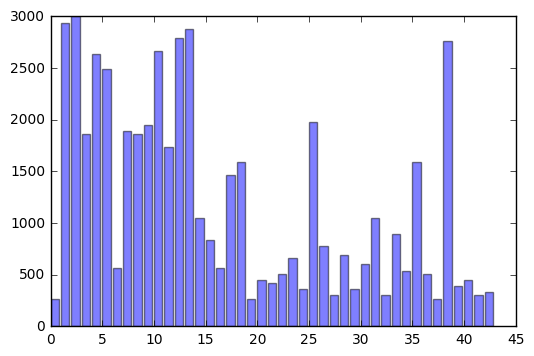

In [5]:
# Create a barchart of frequencies
item, count = np.unique(y_data, return_counts=True)
freq = np.array((item, count)).T

print('%d Observations' % (y_data.shape[0]))
plt.bar(item, count, alpha=0.5)

It is evident that about half of the classes in the dataset do **not** have nearly as many examples as we would want when training a model. It is my judgement that a model trained on this dataset would not have enough examples to accuratly distinguish between classes 0 and 1. 

However, if this dataset represents the true proportions of class frequencies in the real world, we would not want to have an equal bias for class 0 and class 1. When the model is **uncertain**, we want it to predict class 1 (which is more frequent in the real world), but we also want it to be **capable** of predicting class 0. There is a fine line between inserting representational capability or non-exsistant bias into a model when augmenting a dataset.

When we address this issue later, I will outline my attempt to resolve this issue.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [58]:
def pre_process_gray(images):
    # Convert images to grayscale
    tmp = []
    for i in range(images.shape[0]):
        gray = cv2.cvtColor(images[i,...], cv2.COLOR_BGR2GRAY)
        gray = cv2.equalizeHist(gray)
        
        # mu = np.mean(gray)
        # sigma = np.std(gray)
        # norm_grey = (gray-mu)/sigma
        norm_grey = gray/255. - 0.5
        
        tmp.append(norm_grey)
    tmp = np.array(tmp)
    return tmp[...,np.newaxis]

def one_hot(array):
    return np.array([[1 if j == array[i] else 0 for j in range(n_classes)]
                     for i in range(len(array))])

def de_one_hot(array):
    return np.array([i.argmax() for i in array])

In [59]:
X_data = pre_process_gray(X_data)
print("Data Dims:\nData: %r | Labels: %r\n" % (X_data.shape, y_data.shape))

Data Dims:
Data: (51839, 32, 32, 1) | Labels: (51839,)



### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

Function to create random transformations of an image. Credit to Vivek Yadav.

In [8]:
def transform_image(img,ang_range,shear_range,trans_range):
    """
    This function transforms images to generate new images.
    
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    """
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img

Test transformations

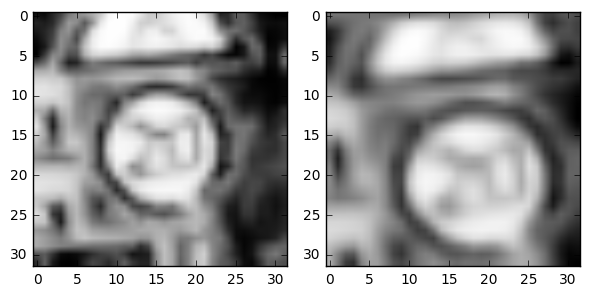

In [9]:
im = 0

transformed = transform_image(X_data[im,...], 20, 10, 5)
stacked = np.dstack((X_data[im,...], transformed))

grid = plt.subplot(1,2,1)
plt.imshow(stacked[...,0], cmap='gray')

grid = plt.subplot(1,2,2)
plt.imshow(transformed, cmap='gray')

plt.tight_layout()

Segragate the dataset into goups of individual classes

In [10]:
segregated_data = []
class_obs = []

for class_ in range(n_classes):
    segregated_class = X_data[y_data == class_,...]
    segregated_data.append(segregated_class)
    class_obs.append(segregated_class.shape[0])

TODO: Explain the below dim

In [11]:
def expand_class(images, n_obs):
    transformed_images = []
    
    if n_obs < 500: factor = 4
    elif n_obs < 1000: factor = 2
    else: return (images, images.shape[0])
    
    for image in images:
        for _ in range(factor-1):
            transformed_images.append(transform_image(image, 20, 10, 5))
    
    transformed_images = np.array(transformed_images)
    transformed_images = transformed_images[...,np.newaxis]
    expanded_class = np.concatenate((images, transformed_images), axis=0)
    return (expanded_class, expanded_class.shape[0])

In [12]:
expanded_data = None
expanded_labels = None

for class_, images in enumerate(segregated_data):
    if expanded_data is None:
        expanded_data, obs = expand_class(images, class_obs[class_])
        expanded_labels = np.full(obs, class_, dtype='int64')
    else:
        tmp, obs = expand_class(images, class_obs[class_])
        expanded_data = np.concatenate((expanded_data, tmp), axis=0)
        expanded_labels = np.concatenate((expanded_labels, np.full(obs, class_, dtype='int64')), axis=0)

del segregated_data, class_obs
print("Expanded Data Dims:\nData: %r | Labels: %r\n" % (expanded_data.shape, expanded_labels.shape))

Expanded Data Dims:
Data: (72418, 32, 32, 1) | Labels: (72418,)



72418 Observations


<Container object of 43 artists>

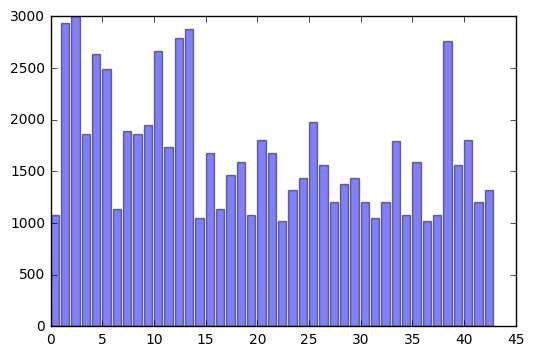

In [13]:
# Create a barchart of frequencies
item, count = np.unique(expanded_labels, return_counts=True)
freq = np.array((item, count)).T

print('%d Observations' % (expanded_labels.shape[0]))
plt.bar(item, count, alpha=0.5)

In [14]:
def shuffle(X, y=None):
    """
    Given data (X) and labels (y), randomly shuffles their order.
    """
    X_shuffled, y_shuffled = [],[]
    n_obs = X.shape[0]

    for i in np.random.permutation(n_obs):
        X_shuffled.append(X[i,...])

        if y is None: y_shuffled.append(0)
        else: y_shuffled.append(y[i,...])
    return (np.array(X_shuffled), np.array(y_shuffled))

def train_val_test_split(data, labels, split_percents):
    n_obs = data.shape[0]
    assert n_obs == labels.shape[0], "Different number of images and labels"
    
    assert np.sum(split_percents) == 1, "Data splits must sum to 1"
    train_percent, val_percent, test_percent = split_percents
    
    data, labels = shuffle(data, labels)
    
    train_cutoff = np.round(train_percent * n_obs).astype('int64')
    test_cutoff = np.round((1-test_percent) * n_obs).astype('int64')
    
    train = (data[:train_cutoff,...], labels[:train_cutoff])
    val = (data[train_cutoff:test_cutoff,...], labels[train_cutoff:test_cutoff])
    test = (data[test_cutoff:,...], labels[test_cutoff:])
    
    assert train[0].shape[0] + val[0].shape[0] + test[0].shape[0] == n_obs, "I fucked up"
    return (train, val, test)

In [15]:
train_percent = 0.75
val_percent = 0.15
test_percent = 0.1
split_percents = (train_percent, val_percent, test_percent)

expanded_labels = one_hot(expanded_labels)
train, val, test = train_val_test_split(expanded_data, expanded_labels, split_percents)

print("Train Size: %d | Val Size: %d | Test Size: %d"
     % (train[0].shape[0], val[0].shape[0], test[0].shape[0]))

Train Size: 54314 | Val Size: 10862 | Test Size: 7242


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

# MODEL 1

In [16]:
def leaky_relu(x, alpha=0.1):
    import tensorflow as tf
    
    alpha = tf.constant(alpha)
    return tf.maximum(alpha*x, x)

In [36]:
from models import ConvNet

SignClassifier = ConvNet(batch_size=64, color_channels=1, image_shape=(32,32), 
                         n_classes=43, learning_rate=1e-3)

SignClassifier.conv2d('L0', kernel_size=1, depth=3, ACTIVATION=leaky_relu)

SignClassifier.conv2d('L1_1', kernel_size=3, depth=32, input_padding=1, ACTIVATION=leaky_relu)
SignClassifier.conv2d('L1_2', kernel_size=3, depth=32, input_padding=1, ACTIVATION=leaky_relu)
SignClassifier.pool2d('MAX')

SignClassifier.conv2d('L2_1', kernel_size=5, depth=64, input_padding=2, ACTIVATION=leaky_relu)
SignClassifier.conv2d('L2_2', kernel_size=5, depth=64, input_padding=2, ACTIVATION=leaky_relu)
SignClassifier.pool2d('MAX')

SignClassifier.conv2d('L3_1', kernel_size=3, depth=128, input_padding=1, ACTIVATION=leaky_relu)
SignClassifier.conv2d('L3_2', kernel_size=3, depth=128, input_padding=1, ACTIVATION=leaky_relu)
SignClassifier.pool2d('MAX')

SignClassifier.fully_connected('FC1', 1024)
SignClassifier.fully_connected('FC2', 512)



### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [38]:
SignClassifier.train(train, val, training_epochs=100, l2_beta=0.001, threshold=0.985)

Starting training process:
 Epoch: 0024 | Validation Accuracy: 0.985661745 | Change: 0.0194093595
Validation accuracy threshold reached!

Optimization Finished!! Training time: 00h:24m:43s


Normalized confusion matrix
Accuracy: 0.98550


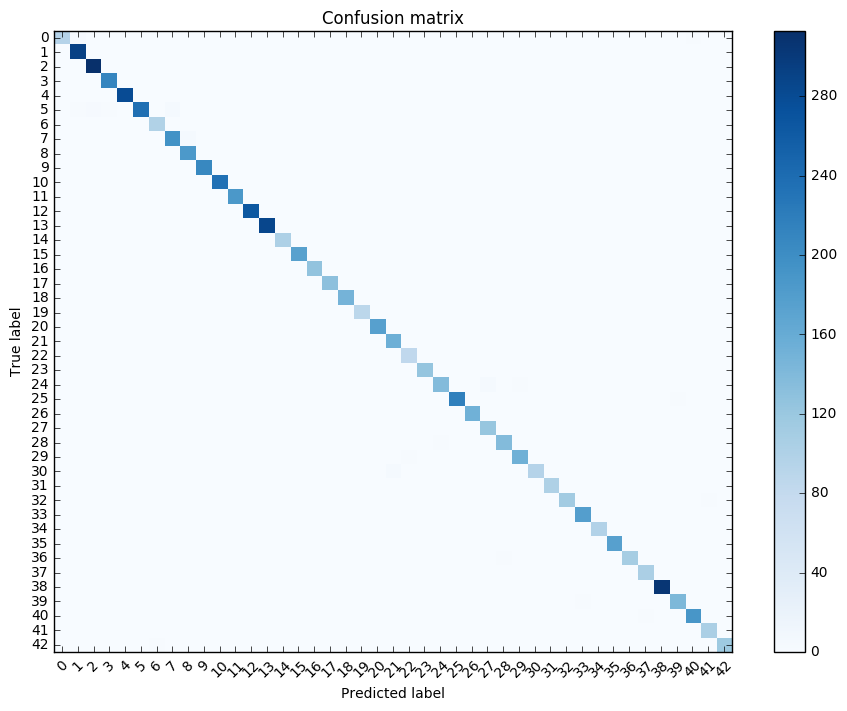

In [39]:
print("Accuracy: %1.5f" % (SignClassifier.score(test, plot=True, normalize=True)))

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**  

**Optimizer:**  Adam Optimizer  
**Learning Rate:**  0.001  
**Batch Size:**  64  
**Beta for L2-Regularization:**  0.001  

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**  
This project 

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [40]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os
import matplotlib.pyplot as plt
import cv2

test_images = []
path = './test_images/'
for image in os.listdir(path):
    img = cv2.imread(path + image)
    img = cv2.resize(img, (32,32))
    test_images.append(img)

test_images = np.array(test_images)
test_images = pre_process_gray(test_images)

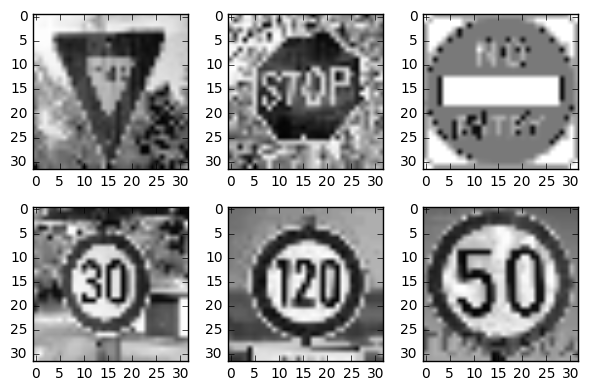

In [41]:
fig = plt.figure()

for i, image in enumerate(test_images):
    grid = plt.subplot(2,3,i+1)
    grid.imshow(image[...,0], cmap='gray')

plt.tight_layout()
plt.show()

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [42]:
import pandas as pd

labels = [13, 14, 17, 1, 8, 2]
pred = [i.argmax() for i in SignClassifier.predict(test_images)]

df = pd.DataFrame(data=np.array((labels, pred)).T, columns=['Labels', 'Predictions'])
acc = SignClassifier.score((test_images, one_hot(labels)))

print('Accuracy: %1.5f\n\n' % (acc), df)

Accuracy: 0.83333

    Labels  Predictions
0      13           13
1      14           14
2      17           17
3       1            1
4       8            8
5       2            4


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [43]:
def vizualize_softmax_probabilities(model, image, num_probs):
    import pandas as pd
    import matplotlib.pylab as plt
    
    num_probs += 1
    
    if image.ndim == 3:
        image = image[np.newaxis,...]
    if image.shape[3] > 1:
        image = pre_process_gray(image)
    
    pred = model.predict(image)[0]
    top_k = np.argsort(pred)[:-num_probs:-1]
    
    pred = pd.DataFrame(data=np.array((top_k, pred[top_k])).T, columns=['ClassId', 'Probability'])
    names = pd.read_csv('./signnames.csv', header=0)
    pred = pd.merge(pred, names, how='inner', on='ClassId')
    
    fig = plt.figure(figsize=(11,7))
    grid = plt.subplot(1,2,1)
    plt.imshow(image[0,:,:,0], cmap='gray')
    
    grid = plt.subplot(1,2,2)
    plt.barh(np.arange(num_probs-1)[::-1], np.array(pred['Probability']), align='center')
    plt.xlim([0,1.0])
    plt.yticks(np.arange(num_probs-1)[::-1], np.array(pred['SignName']))
    
    plt.tight_layout()

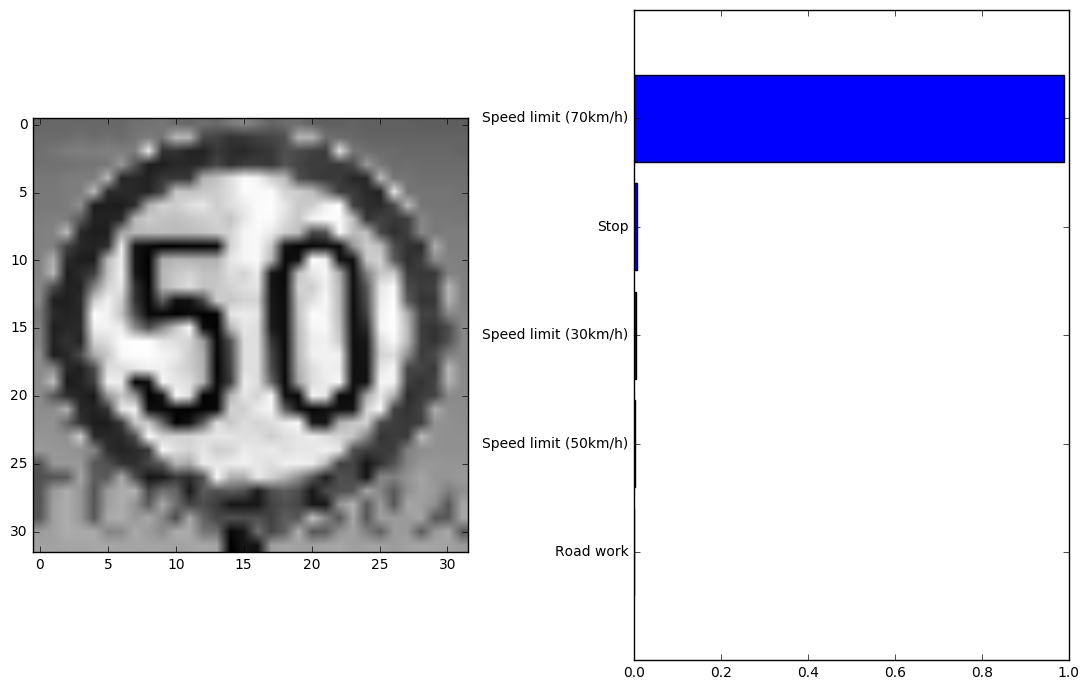

In [44]:
vizualize_softmax_probabilities(SignClassifier, test_images[5], 5)

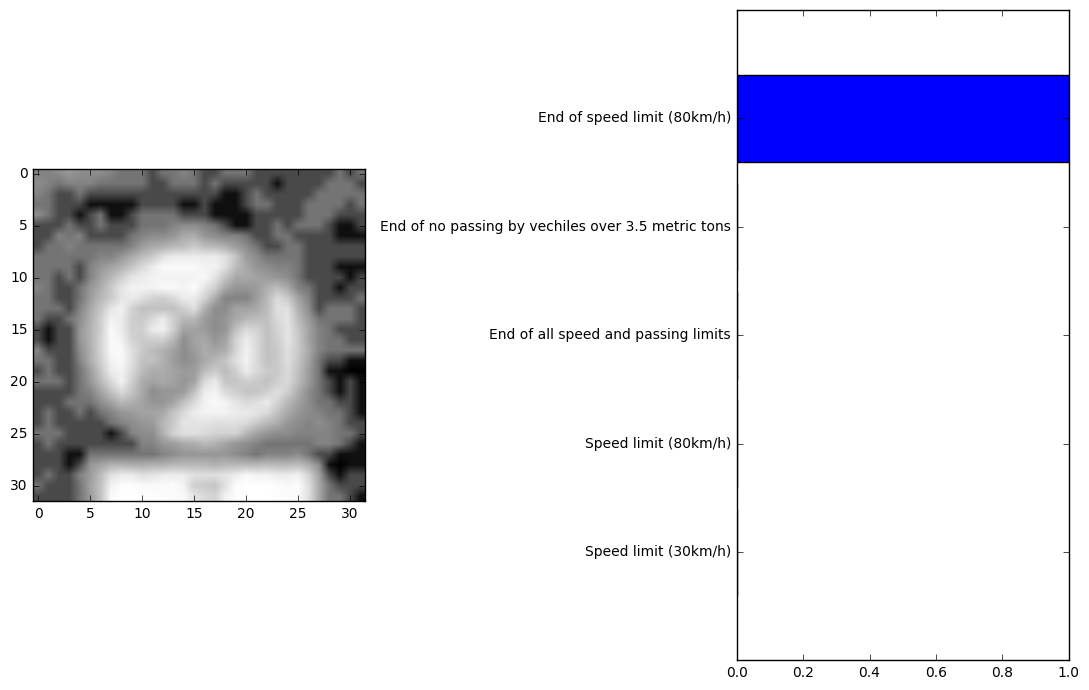

In [45]:
vizualize_softmax_probabilities(SignClassifier, X_train[10000,...], 5)

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.